# 结合PCA和机器学习算法对葡萄酒分类数据集（Wine Dataset）进行分析

## 环境准备,引入库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

## 加载数据

In [2]:
# 加载数据集
data = load_wine()
X = data.data
y = data.target
feature_names = data.feature_names

# 转换为DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# 查看数据统计信息
print(df.describe())
# 检查类别分布
print(df['target'].value_counts())

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

## 数据预处理

In [3]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据（PCA对尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## pca降维

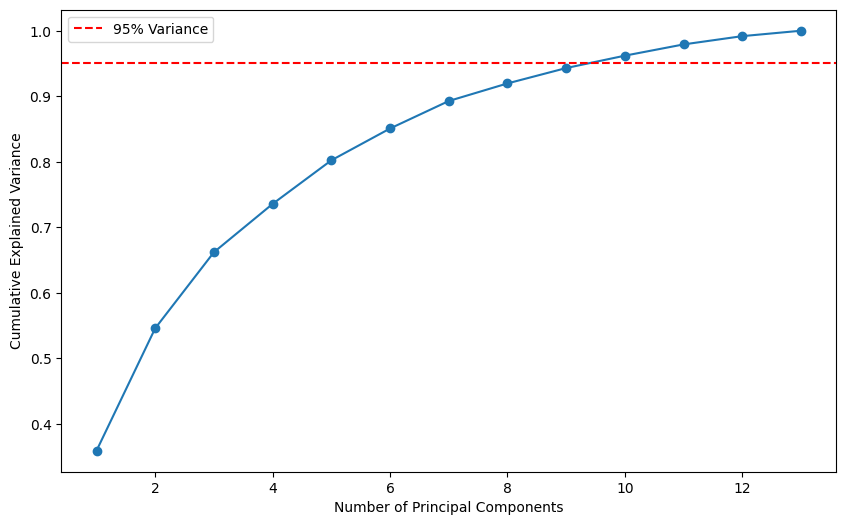

保留95%方差所需的主成分数: 10


In [4]:
# 应用PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# 计算累积方差贡献率
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 可视化方差贡献
plt.figure(figsize=(10,6))
plt.plot(range(1,14), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# 选择保留95%方差的主成分数
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"保留95%方差所需的主成分数: {n_components}")

# 重新应用PCA
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## 可视化前两个主成分

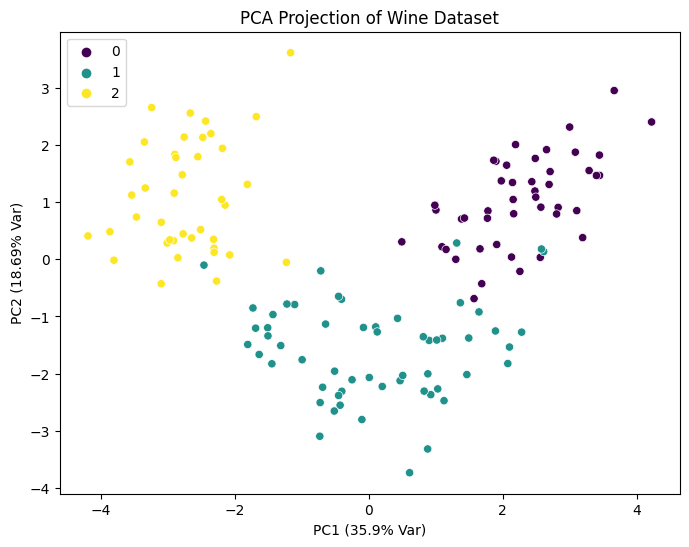

In [5]:
# 使用前两个主成分进行可视化
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca_2d[:,0], y=X_pca_2d[:,1], hue=y_train, palette='viridis')
plt.xlabel('PC1 ({}% Var)'.format(round(pca_2d.explained_variance_ratio_[0]*100,2)))
plt.ylabel('PC2 ({}% Var)'.format(round(pca_2d.explained_variance_ratio_[1]*100,2)))
plt.title('PCA Projection of Wine Dataset')
plt.show()

## 机器模型学习比较
### 使用svm未经过pca降维

In [6]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"SVM原始数据准确率: {accuracy_original:.4f}")

SVM原始数据准确率: 1.0000


### 使用pca降维数据训练svm

In [7]:
svm_pca = SVC(kernel='rbf', random_state=42)
svm_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"SVM+PCA准确率: {accuracy_pca:.4f}")

SVM+PCA准确率: 1.0000


保留95%方差的训练结果仍然达到百分百的精确度，同时降低了训练复杂度。

## 展示pca降维前后训练模型推理结果的混淆矩阵对比

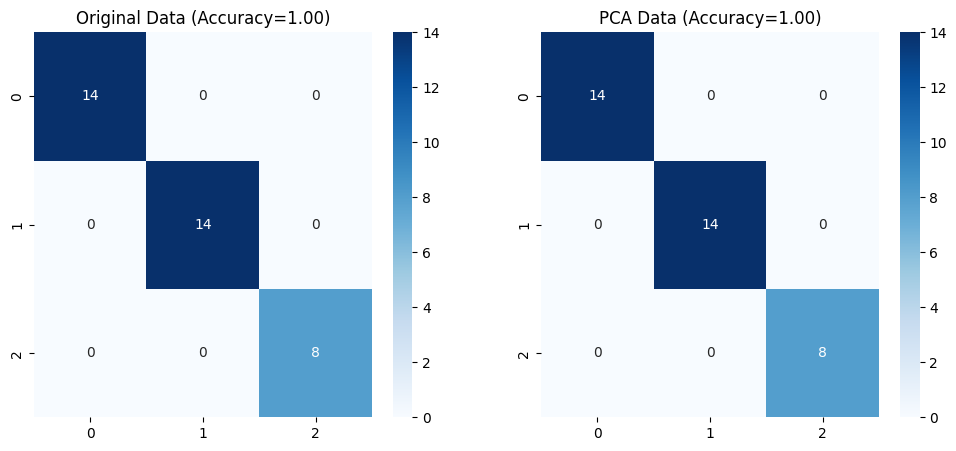

In [8]:
# 混淆矩阵对比
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Original Data (Accuracy={:.2f})'.format(accuracy_original))

sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('PCA Data (Accuracy={:.2f})'.format(accuracy_pca))
plt.show()